# Import Libraries

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from glob import glob
from pathlib import Path
import time

# Load & Preprocess Data

In [28]:
men_paths = glob(r"Data\man\*")
women_paths = glob(r"Data\woman\*")

In [29]:
men_imgs = np.array([tf.cast(np.array(Image.open(path).resize((260,260))),tf.float32) for path in men_paths])
women_imgs = np.array([tf.cast(np.array(Image.open(path).resize((260,260))),tf.float32) for path in women_paths])

In [30]:
men_imgs.shape

(100, 260, 260, 3)

In [31]:
imgs = np.concatenate([women_imgs,men_imgs])
labels = np.concatenate([np.zeros((len(women_imgs),1)),np.ones((len(men_imgs),1))])

In [32]:
imgs.shape

(200, 260, 260, 3)

In [33]:
BATCH_SIZE = 15
dataset = tf.data.Dataset.from_tensor_slices((imgs,labels)).shuffle(100).shuffle(150)
train_set = dataset.take(150).shuffle(50).batch(BATCH_SIZE)
valid_set = dataset.skip(150).take(20).batch(BATCH_SIZE)
test_set = dataset.skip(170).batch(BATCH_SIZE)

In [34]:
tf.data.experimental.cardinality(train_set)

<tf.Tensor: shape=(), dtype=int64, numpy=10>

# Build & Train Model

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import Dense,GlobalAvgPool2D,Dropout
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

In [36]:
base_model = EfficientNetB2()
base_model.load_weights(r"EfficientNetB2_Weights.h5")

In [37]:
base_model.trainable = False

In [38]:
avg = GlobalAvgPool2D()(base_model.layers[-4].output)
dropout = Dropout(0.2)(avg)
out = Dense(1,sigmoid)(dropout)
model = Model(inputs = [base_model.input],outputs = [out])

In [39]:
model.compile(loss = 'binary_crossentropy',
              optimizer= Nadam(),
              metrics = ['accuracy'])

In [45]:
# Tensorboard Initialization to track training if needed(I am not using it right now)
def get_run_logdir(root_logdir="my_logs"):
 return Path(root_logdir) / time.strftime("run_%Y_%m_%d_%H_%M_%S")
tensorboard_cb = TensorBoard(get_run_logdir(),
 profile_batch=(100, 200),histogram_freq=1)

In [40]:
early_stopping_cb = EarlyStopping(patience=2,restore_best_weights=True)

In [41]:
history = model.fit(train_set,epochs = 10,validation_data=valid_set,callbacks = [early_stopping_cb])

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.6437 - loss: 0.6409 - val_accuracy: 0.8500 - val_loss: 0.5544
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8041 - loss: 0.5049 - val_accuracy: 1.0000 - val_loss: 0.3804
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8884 - loss: 0.4071 - val_accuracy: 0.9500 - val_loss: 0.3484
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9245 - loss: 0.3624 - val_accuracy: 0.9000 - val_loss: 0.3240
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9585 - loss: 0.2623 - val_accuracy: 0.9000 - val_loss: 0.2620
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9183 - loss: 0.2508 - val_accuracy: 0.9500 - val_loss: 0.2360
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9094 - loss: 0.2414 - val_accuracy: 0.9500 - val_loss: 0.2579
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9406 - loss: 0.1827 - val_accuracy: 0.9500 - val_loss:

<Axes: >

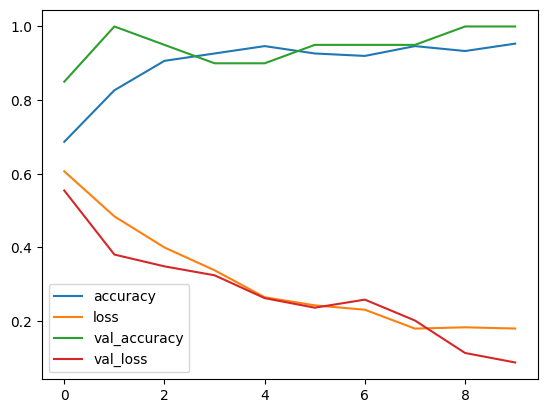

In [42]:
pd.DataFrame(history.history).plot()

In [43]:
model.evaluate(test_set)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9111 - loss: 0.1900


[0.17305132746696472, 0.9333333373069763]

In [51]:
# Convert it to TFLite Model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('gender_recognizer.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpgz3l0ufx\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpgz3l0ufx\assets


Saved artifact at 'C:\Users\User\AppData\Local\Temp\tmpgz3l0ufx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 260, 260, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2699894309136: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2699894308944: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2697415134288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2697415133712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2697415132560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2697415133520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2697415133904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2697415136208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2697415135632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2697415134864: TensorSpec(shape=(), dtype=tf.resource, 